In [6]:
import os
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import data as pdr
import matplotlib.dates as mdates
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import plotly.graph_objects as go

In [7]:
yf.pdr_override() 
df_amazon = pdr.get_data_yahoo("AMZN", start="2016-01-01", end="2023-09-30")

[*********************100%%**********************]  1 of 1 completed


In [8]:
print(df_amazon.shape)
df_amazon.head()

(1949, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,32.814499,32.886002,31.375500,31.849501,31.849501,186290000
2016-01-05,32.342999,32.345501,31.382500,31.689501,31.689501,116452000
2016-01-06,31.100000,31.989500,31.015499,31.632500,31.632500,106584000
2016-01-07,31.090000,31.500000,30.260500,30.396999,30.396999,141498000
2016-01-08,30.983000,31.207001,30.299999,30.352501,30.352501,110258000


## Moving Average Convergence Divergence (MACD)

The Moving Average Convergence Divergence (MACD) is a momentum indicator that helps identify potential trend reversals and crossovers. 

The MACD line is calculated as the difference between the 12-day Exponential Moving Average (EMA) and the 26-day EMA. The Signal Line is a 9-day EMA of the MACD. 

Buy signals are generated when the MACD crosses above the Signal Line, indicating potential upward momentum. Conversely, sell signals occur when the MACD crosses below the Signal Line, suggesting potential downward momentum.


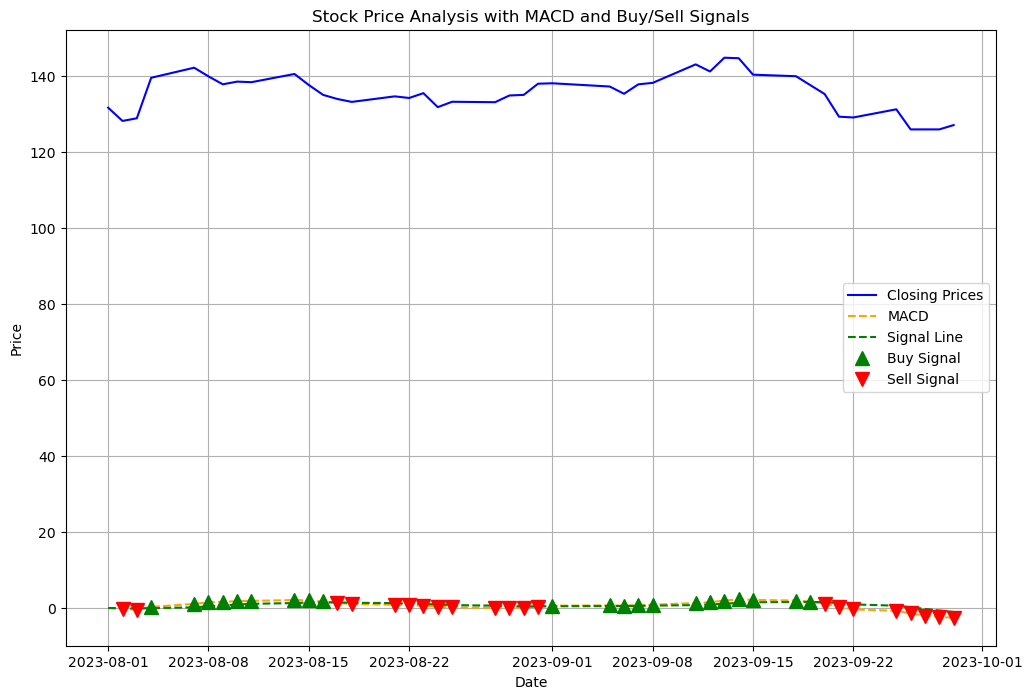

In [9]:
df = df_amazon['2023-08-01':] # 2 months

# Function to calculate Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# Function to generate buy/sell signals based on MACD crossovers
def generate_signals(data):
    signals = pd.DataFrame(index=data.index)
    signals['Buy_Signal'] = 0.0
    signals['Sell_Signal'] = 0.0

    # Buy signal: MACD crosses above Signal line
    signals.loc[data['MACD'] > data['Signal_Line'], 'Buy_Signal'] = 1.0

    # Sell signal: MACD crosses below Signal line
    signals.loc[data['MACD'] < data['Signal_Line'], 'Sell_Signal'] = -1.0

    return signals

# Set parameters for MACD calculation
short_window = 12
long_window = 26
signal_window = 9

# Calculate MACD and Signal Line
df['MACD'], df['Signal_Line'] = calculate_macd(df, short_window, long_window, signal_window)

# Generate buy/sell signals
signals = generate_signals(df)

# Plotting the Closing Prices, MACD, Signal Line, Buy, and Sell signals
plt.figure(figsize=(12, 8))
plt.plot(df['Close'], label='Closing Prices', color='blue')
plt.plot(df['MACD'], label='MACD', linestyle='--', color='orange')
plt.plot(df['Signal_Line'], label='Signal Line', linestyle='--', color='green')

plt.plot(signals.loc[signals['Buy_Signal'] == 1.0].index, df['MACD'][signals['Buy_Signal'] == 1.0], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(signals.loc[signals['Sell_Signal'] == -1.0].index, df['MACD'][signals['Sell_Signal'] == -1.0], 'v', markersize=10, color='r', label='Sell Signal')

plt.title('Stock Price Analysis with MACD and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


The plot above displays the closing prices of the stock along with the MACD and Signal Line. Buy signals are marked with green upward-pointing triangles, and sell signals are marked with red downward-pointing triangles. These signals can assist in making decisions on when to buy or sell the stock based on MACD crossovers.


## Relative Strength Index (RSI) & Comodity Channel Index (CCI)

### Relative Strength Index (RSI)

The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. It ranges from 0 to 100 and is typically used to identify overbought or oversold conditions in a market. A common interpretation is that RSI values above 70 indicate overbought conditions, while values below 30 indicate oversold conditions.


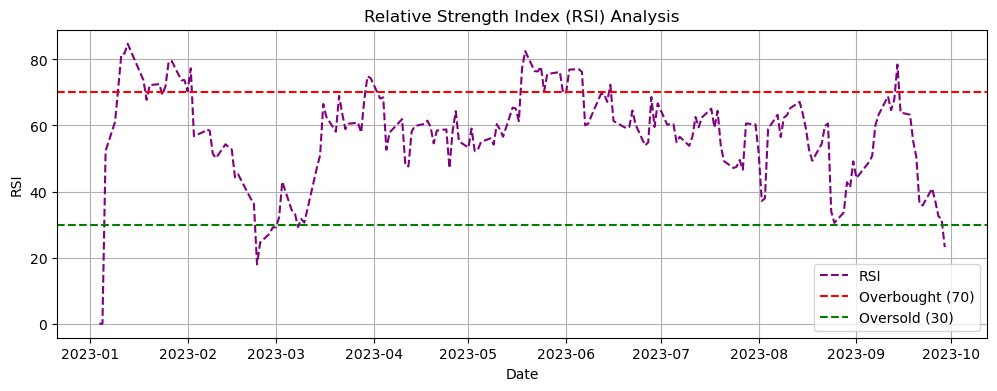

In [10]:
df = df_amazon['2023-01-01':] 

# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(data, window):
    close_price = data['Close']
    daily_price_change = close_price.diff(1)
    gains = daily_price_change.where(daily_price_change > 0, 0)
    losses = -daily_price_change.where(daily_price_change < 0, 0)
    avg_gain = gains.rolling(window=window, min_periods=1).mean()
    avg_loss = losses.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# RSI calculation
rsi_window = 14
df['RSI'] = calculate_rsi(df, rsi_window)

# Plotting RSI
plt.figure(figsize=(12, 4))
plt.plot(df['RSI'], label='RSI', color='purple', linestyle='--')

# horizontal lines for overbought and oversold conditions
plt.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='green', linestyle='--', label='Oversold (30)')

plt.title('Relative Strength Index (RSI) Analysis')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()

### Commodity Channel Index (CCI)

The Commodity Channel Index (CCI) is another momentum indicator that measures the current price level relative to an average price level over a specified period. Similar to RSI, CCI is used to identify overbought or oversold conditions. CCI values above 100 may indicate overbought conditions, while values below -100 may indicate oversold conditions.


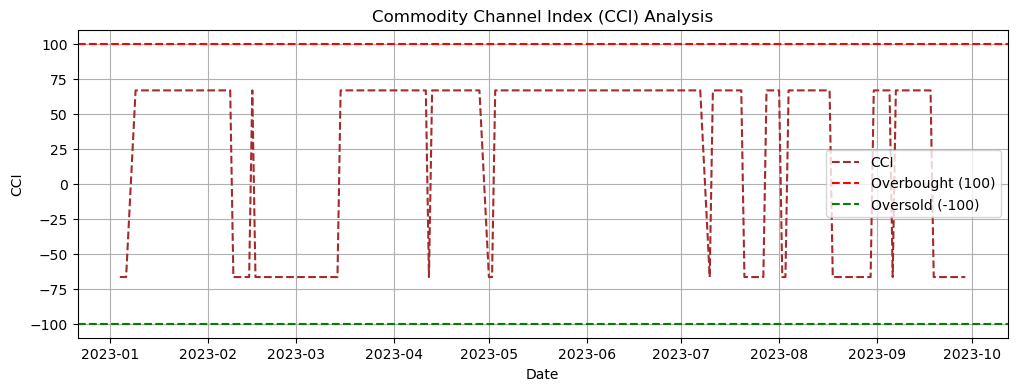

In [11]:
df = df_amazon['2023-01-01':]  

# Function to calculate Commodity Channel Index (CCI)
def calculate_cci(data, window):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    mean_deviation = abs(typical_price - typical_price.rolling(window=window, min_periods=1).mean())
    cci = (typical_price - typical_price.rolling(window=window, min_periods=1).mean()) / (0.015 * mean_deviation)
    return cci

# Calculate CCI
cci_window = 20
df['CCI'] = calculate_cci(df, cci_window)

# Plotting CCI
plt.figure(figsize=(12, 4))
plt.plot(df['CCI'], label='CCI', color='brown', linestyle='--')

# Add horizontal lines for overbought and oversold conditions
plt.axhline(y=100, color='red', linestyle='--', label='Overbought (100)')
plt.axhline(y=-100, color='green', linestyle='--', label='Oversold (-100)')

# Add labels and title
plt.title('Commodity Channel Index (CCI) Analysis')
plt.xlabel('Date')
plt.ylabel('CCI')
plt.legend()
plt.grid(True)
plt.show()

From the plots it can be seen that RSI and CCI responds differently. 
As RSI is typically calculated based on the average of gains and losses over a specified period, and it compares the magnitude of recent gains to recent losses.
CCI, on the other hand, compares the current typical price to a moving average of typical prices, providing a measure of how far the current price deviates from its average.

## Gaps Analysis 

Gap Up occurs when the opening price of a stock is significantly higher than the previous day's closing price.

Gap Down occurs when the opening price of a stock is significantly lower than the previous day's closing price.


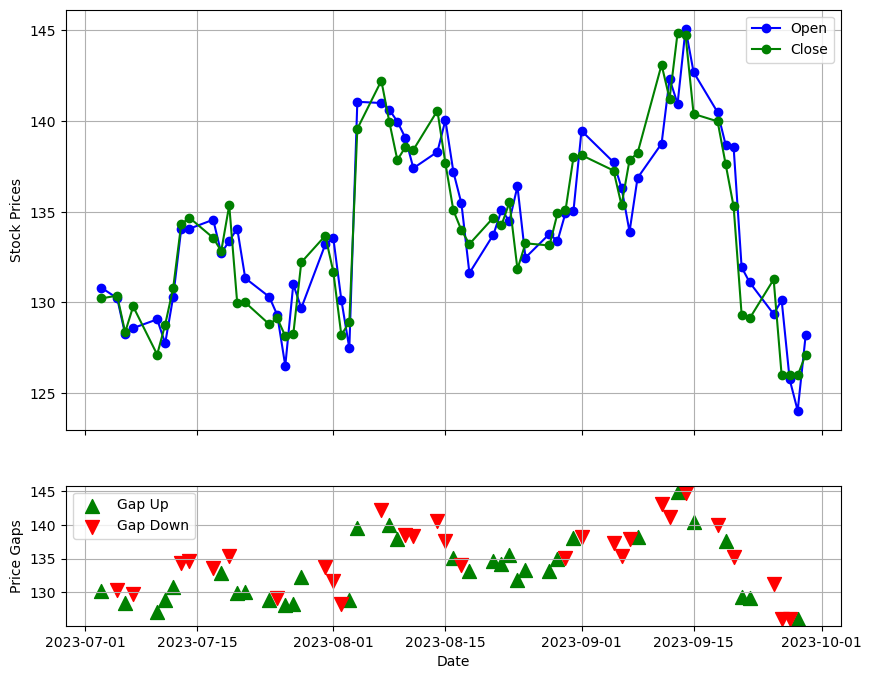

In [29]:
df = df_amazon['2023-07-01':]  

# Calculate price gaps
df['Price_Gap'] = df['Open'].shift(-1) - df['Close']

# Identify where gaps exist
df['Gap_Up'] = df['Price_Gap'] > 0
df['Gap_Down'] = df['Price_Gap'] < 0

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot stock prices as candlestick chart
axs[0].plot(df.index, df['Open'], label='Open', marker='o', linestyle='-', color='blue')
axs[0].plot(df.index, df['Close'], label='Close', marker='o', linestyle='-', color='green')
axs[0].legend()
axs[0].set_ylabel('Stock Prices')
axs[0].grid(True)

# Scatter plot for gap up and gap down
axs[1].scatter(df.index[df['Gap_Up']], df['Close'][df['Gap_Up']], color='green', label='Gap Up', marker='^', s=100)
axs[1].scatter(df.index[df['Gap_Down']], df['Close'][df['Gap_Down']], color='red', label='Gap Down', marker='v', s=100)
axs[1].legend()
axs[1].set_ylabel('Price Gaps')
axs[1].grid(True)
plt.xlabel('Date')
plt.show()


The plot highlights dates where significant Gap Down movements were observed in the stock prices. Gaps in stock prices often indicate strong buying or selling pressure.

KeyError: 'Date'

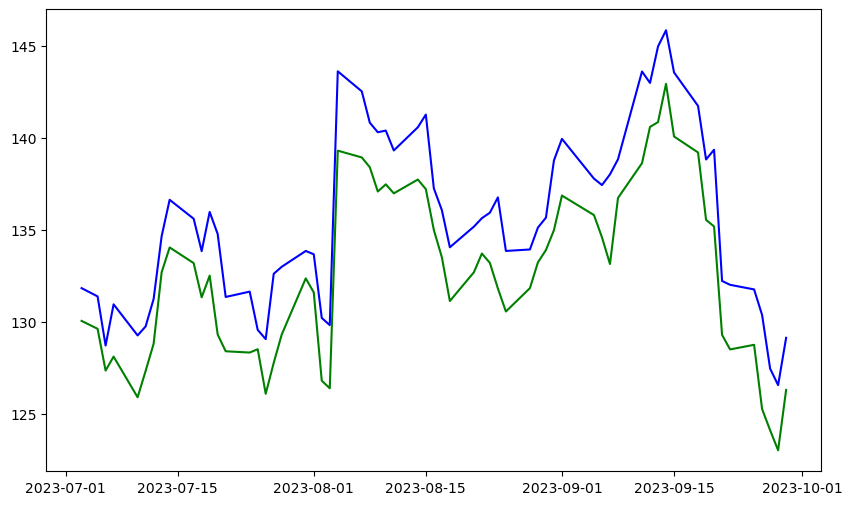

In [34]:
df = df_amazon['2023-07-01':]  

def plot_head_shoulders(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['High'], label='High Prices', color='blue')
    plt.plot(df['Low'], label='Low Prices', color='green')

    # Plot Head and Shoulders Pattern
    left_shoulder = df[df['Date'] == '2023-07-15'][['Date', 'High']].values.flatten()
    head = df[df['Date'] == '2023-07-25'][['Date', 'Low']].values.flatten()
    right_shoulder = df[df['Date'] == '2023-08-05'][['Date', 'High']].values.flatten()

    plt.scatter(left_shoulder[0], left_shoulder[1], marker='^', color='red', label='Left Shoulder')
    plt.scatter(head[0], head[1], marker='o', color='red', label='Head')
    plt.scatter(right_shoulder[0], right_shoulder[1], marker='^', color='red', label='Right Shoulder')

    plt.title('Head and Shoulders Pattern')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_head_shoulders(df)